# DATASET


In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

/Users/comibear/miniconda3/envs/robotics/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MuJoCo:[3.1.6]


In [2]:
dataset = DATASETS[35] # stanford_mask_vit_converted_externally_to_rlds
display_key = 'image'

ds, iterator = get_dataset(dataset, display_key=display_key)

2025-01-25 19:52:00.494780: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


FeaturesDict({
    'episode_metadata': FeaturesDict({
        'file_path': Text(shape=(), dtype=string),
    }),
    'steps': Dataset({
        'action': Tensor(shape=(5,), dtype=float32),
        'discount': Scalar(shape=(), dtype=float32),
        'is_first': bool,
        'is_last': bool,
        'is_terminal': bool,
        'language_embedding': Tensor(shape=(512,), dtype=float32),
        'language_instruction': Text(shape=(), dtype=string),
        'observation': FeaturesDict({
            'end_effector_pose': Tensor(shape=(5,), dtype=float32),
            'finger_sensors': Tensor(shape=(1,), dtype=float32),
            'high_bound': Tensor(shape=(5,), dtype=float32),
            'image': Image(shape=(480, 480, 3), dtype=uint8),
            'low_bound': Tensor(shape=(5,), dtype=float32),
            'state': Tensor(shape=(15,), dtype=float32),
        }),
        'reward': Scalar(shape=(), dtype=float32),
    }),
})


In [3]:
episode = next(iterator)
images = get_image_from_episode(episode, display_key=display_key)

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-01-25 19:52:05.118166: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-25 19:52:12.093871: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE


In [43]:
iter_steps = iter(episode['steps'])
EEF = [eef['observation']['end_effector_pose'] for eef in iter_steps]

iter_steps = iter(episode['steps'])
states = [state['observation']['state'] for state in iter_steps]

2025-01-25 20:16:25.574376: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# ENV


In [57]:
xml_path = '../mujoco_menagerie/rethink_robotics_sawyer/scene.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

In [53]:
def trans_xyz(pos, scales=None, translations=None):
    if scales is None:
        scales = [0.39910943, 0.40094905, 0.08725702]
    if translations is None:
        translations = [0.47534361, -0.19924568,  0.04132169]

    # Convert input list to numpy array if needed
    pos = np.array(pos)
    
    # Transform each coordinate
    transformed = [
        pos[0] * scales[0] + translations[0],
        pos[1] * scales[1] + translations[1], 
        pos[2] * scales[2] + translations[2]
    ]
    
    return transformed

# CONTROL


In [40]:
# Visualize environment with initial pose from trajectory
env.init_viewer(
    title='Tabletop',
    transparent=False,
    azimuth=133,
    distance=3.5,
    elevation=-42.4,
    lookat=(-0.06,0.07,0.31),
)

joint_names = env.joint_names
#q0 = q_traj[0]
q0 = states[0][:7]

env.reset()
env.forward(q=q0, joint_names=joint_names)

while env.is_viewer_alive():
  # env.step()
  if env.loop_every(tick_every=10):
    env.plot_T(
        T=env.get_T_body(body_name='base'),
        axis_len=0.5,print_xyz=False)
    
    env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
    env.plot_contact_info(
        r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)

    env.render()

env.close_viewer()

In [41]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,255],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names

# Don't Know Why.....
# q0 = np.array([0, -1, 0, 1, 6, 1.7, 0])

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = q_traj[0]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos, #np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),s
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


In [9]:
sliders = MultiSliderClass( # Slider for joint control
    n_slider      = 8,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7', 'Gripper'],
    slider_mins   = np.degrees(env.joint_ranges[:,0]).tolist() + [0], # Convert joint ranges from radians to degrees
    slider_maxs   = np.degrees(env.joint_ranges[:,1]).tolist() + [255],
    slider_vals   = [0, 0, 0, 0, 0, 0, 0, 0],
    resolutions   = [(max-min)/50 for min,max in zip(np.degrees(env.joint_ranges[:,0]).tolist() + [0], 
                                                    np.degrees(env.joint_ranges[:,1]).tolist() + [255])],
    verbose       = False,
)

joint_names = env.joint_names

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = q_traj[0]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    joint_values = sliders.get_slider_values()
    
    # Convert degrees to radians for joint angles
    qpos = np.radians(joint_values[:-1])
    
    env.step( # dynamic update
        ctrl        = qpos, # Last value is gripper
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec'%(env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

2025-01-25 19:53:20.687 python[27790:1498132] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-25 19:53:20.687 python[27790:1498132] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Done.


2025-01-25 19:53:25.040 python[27790:1498132] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


# Trajectory


### 1) genration


In [61]:
joint_names = env.joint_names # ['right_j0', 'right_j1', 'right_j2', 'right_j3', 'right_j4', 'right_j5', 'right_j6']
q0 = np.array(states[0][:7])

q_traj = []

q_ik_init = q0.copy()
for ik_target in EEF:
    # temp = quat2rpy(ik_target[3:].numpy())
    # rot_target = rpy2r(temp)

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = trans_xyz(ik_target[:3]), # Convert cm to inches
        R_trgt             = rpy2r([0, 0, -ik_target[3]]),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

### 2) Comparing


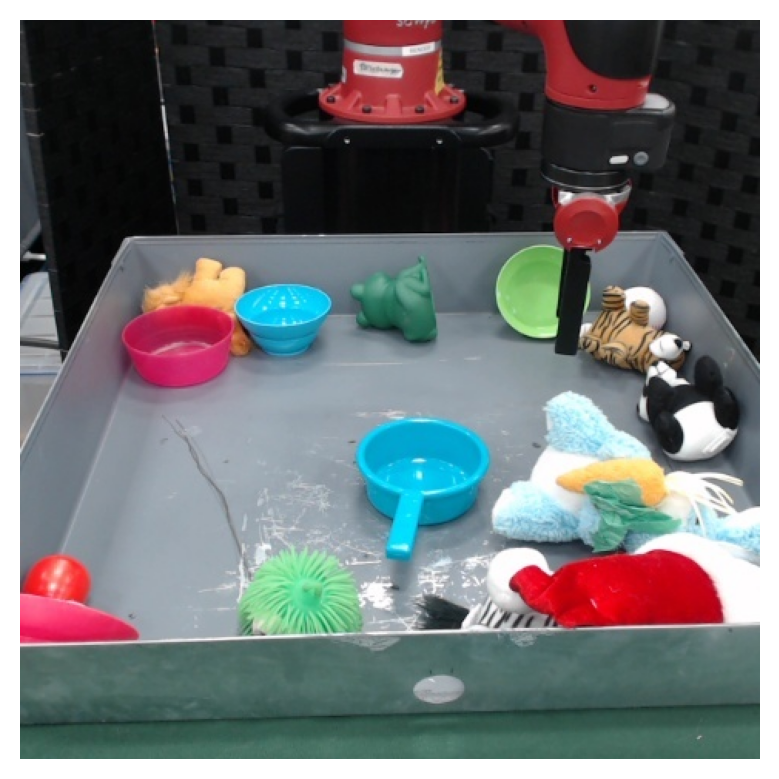

2025-01-24 23:48:48.555 python[25897:1411209] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-24 23:48:48.555 python[25897:1411209] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Done.


2025-01-24 23:49:52.896 python[25897:1411209] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [8]:
# G -> B -> R

idx = -1
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos,
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

# Trajectory Reappearance


In [62]:
joint_names = env.joint_names
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.1):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]
        eef_pos = eef_traj[idx]

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


In [63]:
joint_names = env.joint_names
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = states[0][:7]
idx = 0

eef_traj = [env.get_p_body(body_name='tcp_link') for _ in range(len(states))]

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)
    eef_traj[idx] = env.get_p_body(body_name='tcp_link')

    # Render 
    if env.loop_every(HZ=0.2):

        if idx < len(states)-1:
            idx += 1
        else: idx = 0

        qpos = states[idx][:7]  # Use first 7 joints from joint_states

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


: 

Scale factors (x,y,z): [0.39910943 0.40094905 0.08725702]
Translations (x,y,z): [ 0.47534361 -0.19924568  0.04132169]


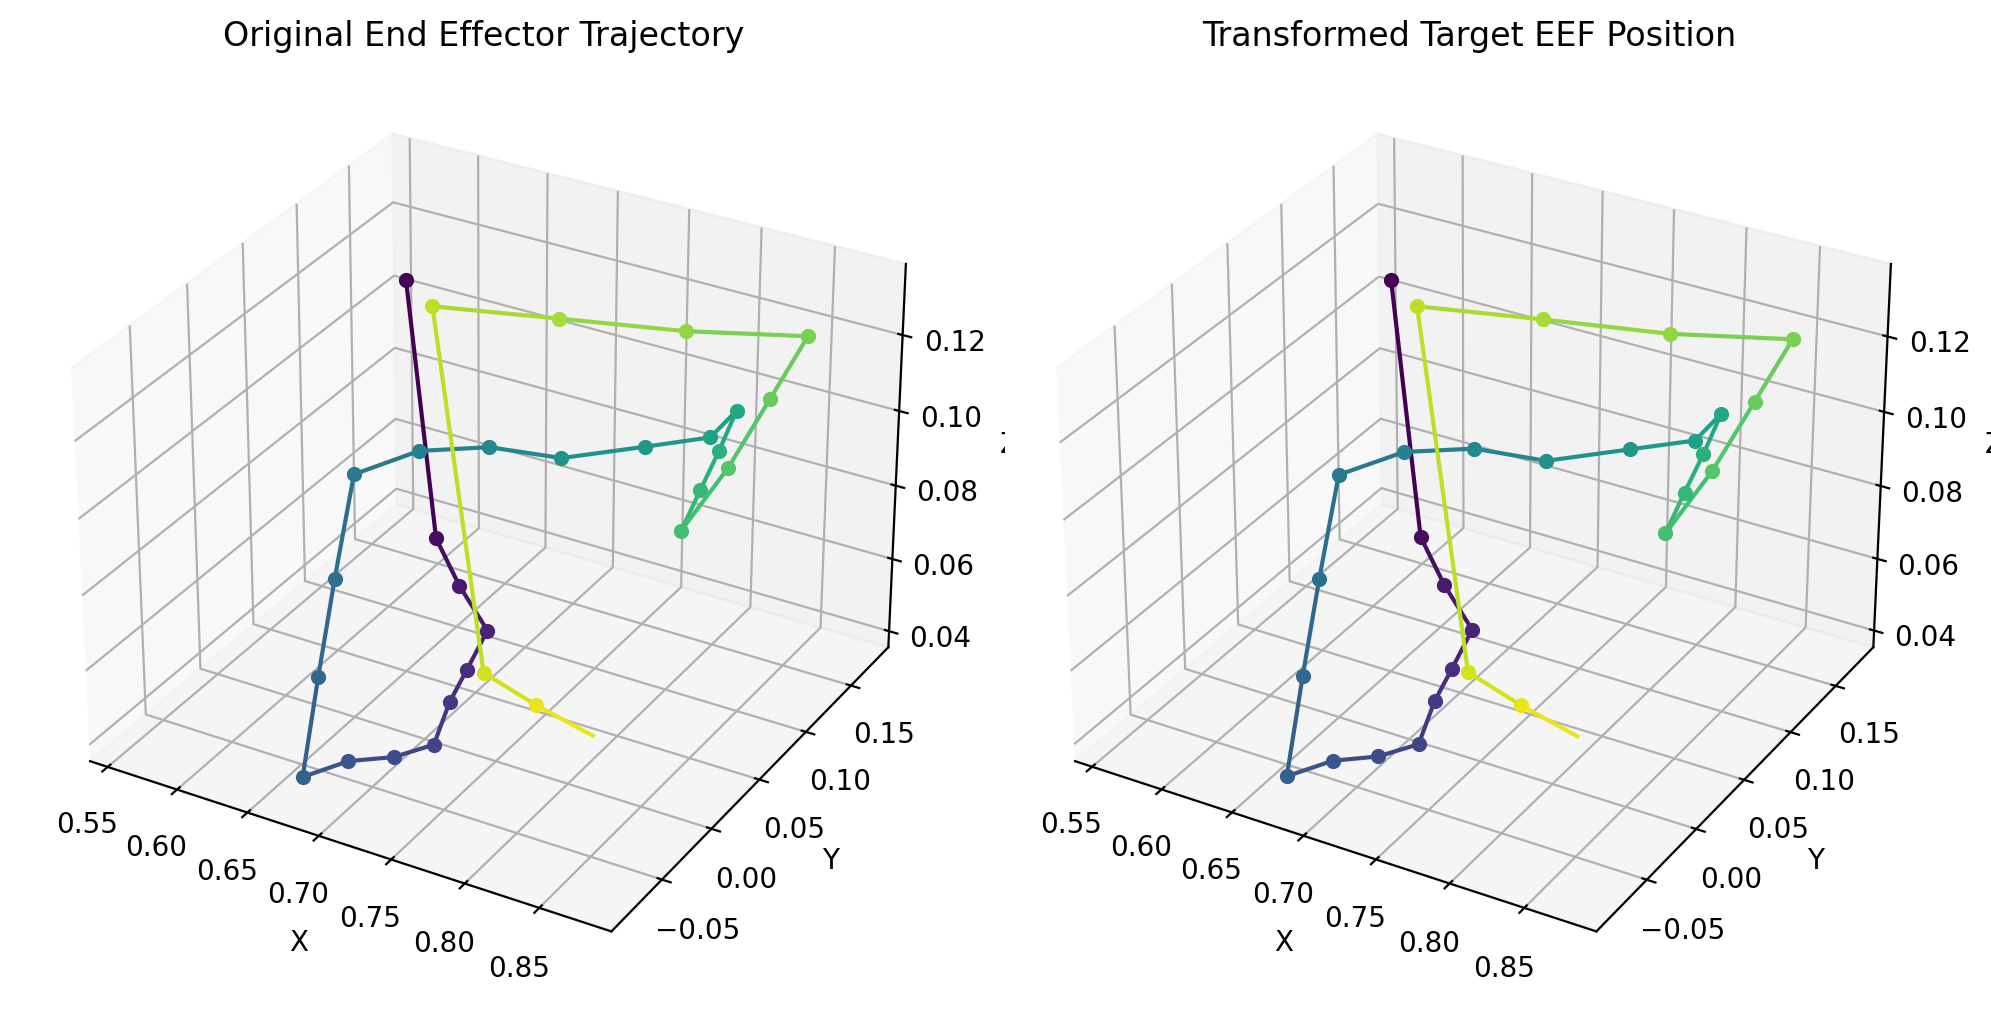

[0.5605179621092233, 0.17439385855412112, 0.10538552237406074] [0.5601198  0.17399453 0.10489745]


In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert lists to numpy arrays for easier computation
eef_array = np.array(eef_traj)
EEF_array = np.array(EEF)[:,:3]  # Only take xyz coordinates

# Calculate inverse scale and translation for each axis
scales = np.zeros(3)
translations = np.zeros(3)

for i in range(3):  # For each x,y,z axis
    # Linear regression to find scale and translation
    A = np.vstack([EEF_array[:,i], np.ones(len(EEF_array))]).T
    scale, translation = np.linalg.lstsq(A, eef_array[:,i], rcond=None)[0]
    scales[i] = scale
    translations[i] = translation

print("Scale factors (x,y,z):", scales)
print("Translations (x,y,z):", translations)

# Transform EEF coordinates to match eef coordinates
transformed_EEF = np.zeros_like(EEF_array)
for i in range(3):
    transformed_EEF[:,i] = EEF_array[:,i] * scales[i] + translations[i]

# Plotting
fig = plt.figure(figsize=(10, 5))

# Create color gradients
colors_eef = plt.cm.viridis(np.linspace(0, 1, len(eef_traj)))
colors_EEF = plt.cm.viridis(np.linspace(0, 1, len(EEF)))

# Plot original eef_traj
ax1 = fig.add_subplot(121, projection='3d')
for i in range(len(eef_traj)-1):
    ax1.scatter(eef_array[i,0], eef_array[i,1], eef_array[i,2],
                c=[colors_eef[i]], marker='o')
    ax1.plot([eef_array[i,0], eef_array[i+1,0]],
             [eef_array[i,1], eef_array[i+1,1]],
             [eef_array[i,2], eef_array[i+1,2]],
             c=colors_eef[i])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z') 
ax1.set_title('Original End Effector Trajectory')

# Plot transformed EEF position
ax2 = fig.add_subplot(122, projection='3d')
for i in range(len(EEF)-1):
    ax2.scatter(transformed_EEF[i,0], transformed_EEF[i,1], transformed_EEF[i,2],
                c=[colors_EEF[i]], marker='o')
    ax2.plot([transformed_EEF[i,0], transformed_EEF[i+1,0]],
             [transformed_EEF[i,1], transformed_EEF[i+1,1]],
             [transformed_EEF[i,2], transformed_EEF[i+1,2]],
             c=colors_EEF[i])

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Transformed Target EEF Position')

plt.tight_layout()
plt.show()

print(trans_xyz(np.array(EEF[0][:3])), eef_traj[0])

# Reverse Engineering


In [42]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = rpy2r([0, 0, -EEF[0][3]])

base = env.get_R_body(body_name='right_l6')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
# print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))


'''
[-5.27306031e-17  9.32701387e-17  1.57079633e+00]
[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]
[ 0.72716463  0.04836099  0.05041956 -0.68289874]
[ 0.70710678  0.          0.         -0.70710678]


[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]
'''

[ 0.01879203 -0.27520886 -0.96115879  0.00898481]


'\n[-5.27306031e-17  9.32701387e-17  1.57079633e+00]\n[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]\n[ 0.72716463  0.04836099  0.05041956 -0.68289874]\n[ 0.70710678  0.          0.         -0.70710678]\n\n\n[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]\n'

In [56]:
target = rpy2r([0, 0, EEF[0][3]])

base = (quat2r([0.01879203, -0.27520886, -0.96115879, 0.00898481]) @ target.T)@rpy2r([0, 0, -EEF[0][3]])
print(r2quat(base))

[ 0.01703441  0.7033638  -0.7105248  -0.01198733]
